In [1]:
import numpy as np
import sympy as sy

import matplotlib.pyplot as plt


import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app


plt.style.use("ggplot")

# System Definition

In [2]:
# One particle in 3D
system = mm.System()
mass = 1.0 * unit.amu 
system.addParticle(mass)




0

## 3D Double Well Potential

### Y and Z dimensions: Harmonic Well

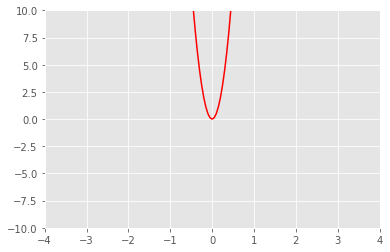

In [3]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [4]:
x = sy.symbols('x')
g=sy.diff(0.5*K*x**2,x)
gg=sy.diff(0.5*K*x**2,x,x)
roots_diff=sy.roots(g,x)
roots_yz=roots_diff

In [5]:
# Period:
print("Oscillation periods T in minima:")
for root in roots_diff.keys():
    freq=gg.subs(x,root)
    if freq>0:
        print(2*np.pi*np.sqrt(mass._value/float(freq)))

Oscillation periods T in minima:
0.6283185307179586


### X dimension: Double Well

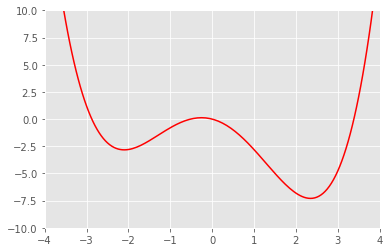

In [6]:
# 'Eo(C*x**4-x**2)+M*x'

def double_well(x,Eo,C,M):
    return Eo*(C*x**4-x**2)+M*x

Eo=2.0
C=0.1
M=-1.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [7]:
x = sy.symbols('x')
g=sy.diff(Eo*(C*x**4-x**2)+M*x,x)
gg=sy.diff(Eo*(C*x**4-x**2)+M*x,x,x)
roots_diff=sy.roots(g,x)
roots_x=roots_diff

In [8]:
# Period:
print("Oscillation periods T in minima:")
for root in roots_diff.keys():
    freq=gg.subs(x,root)
    if freq>0:
        print(np.sqrt(float(freq)/mass._value))

Oscillation periods T in minima:
2.5633021330924413
3.0455802014612066


## Adding potential to the system

In [9]:
K  = K  * unit.kilocalories_per_mole/unit.angstrom**2
Eo = Eo * unit.kilocalories_per_mole/unit.angstrom**2
C  = C  * 1/unit.angstrom**2
M  = M  * unit.kilocalories_per_mole/unit.angstrom

force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K)
force.addGlobalParameter('Eo', Eo)
force.addGlobalParameter('C', C)
force.addGlobalParameter('M', M)
force.addParticle(0, [])
system.addForce(force)

0

## Initial Conditions

In [18]:
position_minimum=np.array([[roots_x.keys()[0],roots_yz[0],roots_yz[0]]],dtype=float32)
initial_positions = unit.Quantity(position_minimum, unit.angstroms)
#initial_velocitiies will be randomly generated according to temperature by function:
#context.setVelocitiesToTemperature(temperature)
initial_positions

TypeError: 'dict_keys' object does not support indexing

# Thermodynamic State Definition

In [11]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin

# Simulation Options

In [12]:
step_size       = 0.001*unit.picoseconds
num_steps       = 100000
saving_period   = 100

friction    = 1/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

## Output arrays and reporters

In [13]:
num_checks     = int(num_steps/saving_period)
times      = unit.Quantity(np.zeros([num_checks], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)

# Context and Initial state of system

In [14]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

NameError: name 'initial_positions' is not defined

In [ ]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Running Simulation

In [ ]:
for ii in range(num_checks):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

--------------

# Results Analysis

In [ ]:
"""
T = sqrt(m/K)
timestep smaller than ~ T/10
standard deviation in each dimension sigma= (kT / K)^(1/2)
Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT
"""